In [750]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [770]:
# klangapi = pd.read_csv('klangapiCleanedHourly.csv')

klangapi = pd.read_csv('klangapiCleanedDailyMean.csv')
klangapi=klangapi.replace(0.0000,np.NaN)
#klangapi[(klangapi == 0.0).any(axis=1)]
klangapi.interpolate(method ='linear', limit_direction ='forward', inplace=True)

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)

klangapi

,wind_speed,wind_direction,temperature,relative_humidity,nox,no,so2,no2,o3,co,pm10
date,,,,,,,,,,,
2002-10-01,4.2125,170.1875,27.3729,72.7500,0.0751,0.0409,0.0097,0.0342,0.0241,2.3044,108.6875
2002-10-02,4.9542,111.8750,27.4375,72.8333,0.0601,0.0247,0.0077,0.0354,0.0203,1.7673,108.3333
2002-10-03,5.0542,123.2083,26.8250,77.0833,0.0610,0.0261,0.0119,0.0349,0.0191,1.7481,99.9583
2002-10-04,3.6958,134.3750,26.4875,79.2500,0.0871,0.0506,0.0121,0.0366,0.0191,2.4892,116.6250
2002-10-05,4.4708,188.9167,26.4750,80.3333,0.0539,0.0305,0.0072,0.0234,0.0165,1.7731,94.9583
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.1170,122.5417,27.7175,83.7624,0.0158,0.0027,0.0009,0.0130,0.0223,0.6674,19.1635
2020-12-28,0.8107,179.2917,27.5274,86.2811,0.0281,0.0082,0.0012,0.0199,0.0159,0.8996,34.3774
2020-12-29,1.1680,162.0000,27.1210,87.1327,0.0247,0.0063,0.0011,0.0184,0.0133,0.8214,23.4586


In [771]:
trainTest=klangapi.loc['2002-01-01':'2017-03-31'].copy() #2002-2017/3/31
verifyDeploy=klangapi.loc['2018-01-01':'2018-12-31'].copy() #2018

In [772]:
trainTest.shape,verifyDeploy.shape

((5296, 11), (365, 11))

In [773]:
klangapiPM10 = trainTest['so2']
klangapiPM10.shape

(5296,)

In [774]:
# #splitting dataset into train and test split
# training_size=int(len(klangapiPM10)*0.90)
# test_size=len(klangapiPM10)-training_size
# train,test = klangapiPM10[0:training_size],klangapiPM10[training_size:len(klangapiPM10)]
# train.shape,test.shape

In [775]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]


def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape

In [776]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(klangapiPM10, WINDOW_SIZE)
X1.shape, y1.shape

((5293, 3, 1), (5293,))

In [777]:
##splitting dataset into train and test split
training_size=int(len(X1)*0.90)
test_size=len(X1)-training_size
X_train1, y_train1 = X1[:training_size], y1[:training_size]
X_test1, y_test1 = X1[training_size:], y1[training_size:]
X_train1.shape,X_test1.shape

((4763, 3, 1), (530, 3, 1))

In [778]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_60 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [779]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics='mse')
model1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=10)

Epoch 1/10
149/149 [==============================] - 0s 3ms/step - loss: 7.5775e-06 - mse: 7.5775e-06 - val_loss: 4.1797e-06 - val_mse: 4.1797e-06
Epoch 2/10
149/149 [==============================] - 0s 1ms/step - loss: 6.3885e-06 - mse: 6.3885e-06 - val_loss: 3.8910e-06 - val_mse: 3.8910e-06
Epoch 3/10
149/149 [==============================] - 0s 1ms/step - loss: 6.1785e-06 - mse: 6.1785e-06 - val_loss: 3.5179e-06 - val_mse: 3.5179e-06
Epoch 4/10
149/149 [==============================] - 0s 1ms/step - loss: 5.9254e-06 - mse: 5.9254e-06 - val_loss: 3.7065e-06 - val_mse: 3.7065e-06
Epoch 5/10
149/149 [==============================] - 0s 1ms/step - loss: 5.7248e-06 - mse: 5.7248e-06 - val_loss: 3.4800e-06 - val_mse: 3.4800e-06
Epoch 6/10
149/149 [==============================] - 0s 1ms/step - loss: 5.5292e-06 - mse: 5.5292e-06 - val_loss: 2.9820e-06 - val_mse: 2.9820e-06
Epoch 7/10
149/149 [==============================] - 0s 1ms/step - loss: 5.3184e-06 - mse: 5.3184e-06 - val_los

In [780]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

,Train Predictions,Actuals
0,0.006672,0.0121
1,0.007030,0.0072
2,0.006794,0.0074
3,0.006197,0.0089
4,0.005890,0.0071
...,...,...
4758,0.004378,0.0029
4759,0.004205,0.0044
4760,0.004301,0.0050
4761,0.004408,0.0056


In [781]:
performance_measure(y_train1,train_predictions)

(0.046593767229529764, 0.0015381518676945067, 39.150030943060074)

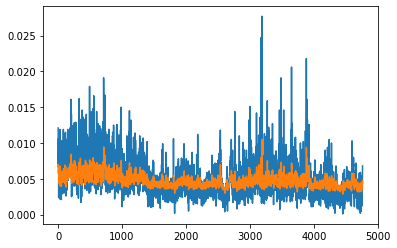

In [782]:
import matplotlib.pyplot as plt
plt.plot(train_results['Actuals'][:])
plt.plot(train_results['Train Predictions'][:])

In [783]:
klangapiPM10 = verifyDeploy['so2']
klangapiPM10.shape

(365,)

In [784]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(klangapiPM10, WINDOW_SIZE)
X1.shape, y1.shape

((362, 3, 1), (362,))

In [785]:
val_predictions = model1.predict(X1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y1})
val_results

,Val Predictions,Actuals
0,0.003136,0.0017
1,0.003212,0.0020
2,0.003354,0.0017
3,0.003451,0.0017
4,0.003446,0.0016
...,...,...
357,0.003548,0.0032
358,0.003746,0.0018
359,0.003580,0.0017
360,0.003596,0.0015


In [786]:
val_results[(val_results < 0.001).any(axis=1)]

,Val Predictions,Actuals
206,0.003379,0.0009
207,0.003271,0.0008
217,0.003434,0.0008
230,0.003331,0.0009
272,0.003428,0.0006
273,0.003229,0.0008
276,0.003168,0.0006
277,0.003122,0.0007
278,0.003068,0.0009


In [787]:
performance_measure(y1,val_predictions)

(0.0408802779524385, 0.0015756868058373092, 98.1813555644682)

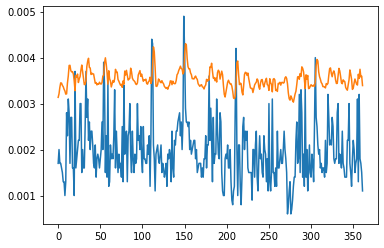

In [788]:
plt.plot(val_results['Actuals'][:])
plt.plot(val_results['Val Predictions'][:])